In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from random import randint, seed
import time

In [2]:
if len(sys.argv) < 3:
    print('''
    usage: python ./tree.py TRAINING TESTING
    TRAINING: file path to csv file of all training objects
    TESTING: path to csv file of all test objects

    both csvs should be output from ldaIsh.py to ensure proper formatting
    ''')
    exit(1)

In [3]:
def graphSaver(filename):
    '''
    Function to save graphs to user's desktop
    Saves to folder called "graph_pictures"
    Input is a string with what you want the file to be called
    '''
    
    directory = 'graph_pictures'

    if not os.path.exists(directory):
        os.makedirs(directory)

    savepath = directory+'/'+filename
    plt.savefig(savepath)

In [4]:
def perf_measure(y_actual, y_hat):
    '''Performs the confusion matrix values
    True positive, True Negative, False Positive, False Negative
    Returns the 4 values as well
    '''
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [5]:
#train = sys.argv[1]
#test = sys.argv[2]
train = 'ltg_3k_training.csv'
test = 'ltg_3k_testing.csv'

In [6]:
tr = pd.read_csv(train)
te = pd.read_csv(test)
names = tr.columns.values.tolist()[0:-1]

In [7]:
te

,topic_0,topic_1,topic_2,label
0,0.160985,0.829867,0.000000,1
1,0.091834,0.884630,0.023536,1
2,0.071155,0.897729,0.031116,1
3,0.299093,0.681239,0.019669,1
4,0.031027,0.821177,0.147796,1
5,0.097299,0.709138,0.193563,0
6,0.281215,0.701304,0.017481,1
7,0.314910,0.669907,0.015183,0
8,0.370863,0.495455,0.133683,0
9,0.159246,0.548889,0.291865,0


In [8]:
Attributes=tr[names]
Labels=tr['label']

In [10]:
#Set variables for random forest evaluation
recordedRecall=0
recordedPrecision=0
recordedAccuracy=0
bestF1=0
realTP=0
realTN=0
realFP=0
realFN=0

In [11]:
#Random forest parameters
nestimators=10
maxdepth=100
repeatRange = 250
model_list = []

In [15]:
#Random forest function
for i in range(repeatRange):
    clf=ensemble.RandomForestClassifier(n_estimators = nestimators, max_depth=maxdepth)
    clf=clf.fit(Attributes, Labels)
    
    yhat = clf.predict_proba(te[names].copy())
    labels = clf.predict(te[names].copy())
    truth = te['label'].values.tolist()
    seed(time.time())
    
    tp, fp, tn, fn = perf_measure(truth, labels)
    
    precision = float(tp/(tp+fp))
    accuracy = (tp+tn)/(tp+tn+fp+fn) 
    recall = float(tp/(tp+fn))
    if precision and recall == 0:
        f1 = 0
    try:
        f1 = 2 * (float(precision * recall) / float(precision + recall))
    except ZeroDivisionError:
        f1 = 0

    if(f1>bestF1):
        bestF1=f1
        recordedAccuracy=accuracy
        recordedPrecision=precision
        recordedRecall=recall
        realTP=tp
        realTN=tn
        realFP=fp
        realFN=fn
        model_list.append(clf)
        best_label = np.array(labels)
        best_yhat = np.array(yhat)

In [16]:
print("Note: tree creation is not always deterministic.")
print("Number of topics: ", len(names))
print("Number of models: ", len(model_list))
print("% of docs that are positive: ", (tp+fn)/(tp+fn+fp+tn))
print("% of docs that are negative: ", (fp+tn)/(tp+fn+fp+tn))

Note: tree creation is not always deterministic.
Number of topics:  3
Number of models:  8
% of docs that are positive:  0.7096774193548387
% of docs that are negative:  0.2903225806451613


In [17]:
#This returns the best score based on the best F1 score
print("TP: ", realTP)
print("FP: ", realFP)
print("TN: ", realTN)
print("FN: ", realFN)
print()
print("Precision: ", recordedPrecision)
print("Accuracy:  ", recordedAccuracy)
print("Recall:    ", recordedRecall)
print("F1:        ", bestF1)

TP:  20
FP:  8
TN:  1
FN:  2

Precision:  0.7142857142857143
Accuracy:   0.6774193548387096
Recall:     0.9090909090909091
F1:         0.8


In [18]:
best_label

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1])

In [19]:
truth2 = np.array(truth)
labels2 = np.array(best_label)
print("These are the labels: ", truth2)
print("These are the predicted labels after classification: ", labels2)

These are the labels:  [1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0]
These are the predicted labels after classification:  [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1]


In [20]:
cr = classification_report(truth2, labels2, labels=[0,1])
ar = accuracy_score(truth2, labels2)
fs = f1_score(truth2, labels2)
print(cr, ar, fs)

              precision    recall  f1-score   support

           0       0.33      0.11      0.17         9
           1       0.71      0.91      0.80        22

    accuracy                           0.68        31
   macro avg       0.52      0.51      0.48        31
weighted avg       0.60      0.68      0.62        31
 0.6774193548387096 0.8


In [21]:
realTP

20

In [22]:
pos_probs = best_yhat[:,1]

In [23]:
#d2pprobs = np.array(yhat)

In [24]:
precision2, recall2, thresholds = precision_recall_curve(truth2, pos_probs)

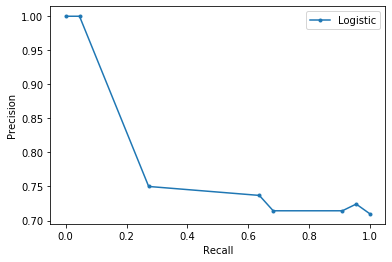

In [25]:
'''
Process for creating precision-recall curve
Not used in this proejct, but for analysis purposes
'''
lr_precision, lr_recall, _ = precision_recall_curve(truth2, pos_probs)

lr_f1, lr_auc = f1_score(truth2, labels2), auc(recall2, precision2)

plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [26]:
auc_score = auc(recall2, precision2)
roc_auc_result = roc_auc_score(truth2, pos_probs)
print(auc_score)
print(roc_auc_result)

0.7752491090959271
0.5454545454545454


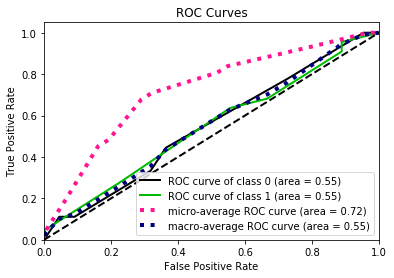

In [27]:
skplt.metrics.plot_roc(truth2, best_yhat)
#Save figure below with the followin function
graphSaver('roc-3topics.png')

In [28]:
def make_confusion_matrix(y_test, y_predictor, filename=''):
    '''
    Confusion matrix generation integrated with optional save function
    Returns confusion matrix in array form
    '''
    cm=confusion_matrix(y_test, y_predictor, labels=[1, 0])
    index = ['Positve','Negative']  
    columns = ['Positive','Negative']
    cm_df = pd.DataFrame(cm, columns, index)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    display(cm_df)
    
    #Clear previous plot
    plt.clf()
    plt.cla()

    sns.heatmap(cm_df, annot=True)
    
    if filename != '':
        graphSaver(filename)
        
    return(cm)

Predicted,Positve,Negative
Actual,,
Positive,20,2
Negative,8,1


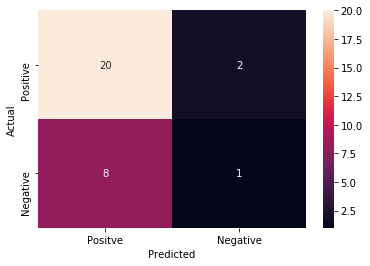

In [29]:
conf_matrix = make_confusion_matrix(truth2, labels2, 'conf-matrix-3k.png')